In [142]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os
from sklearn.model_selection import ShuffleSplit

import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam # - Works

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers


pathDefectTile = "C:/Users/schof/LeedsUni/personalproject/DefectTiles/"
pathDefectTileStrict = "C:/Users/schof/LeedsUni/personalproject/tiles/defect/"
pathGoodTile = "C:/Users/schof/LeedsUni/personalproject/tiles/normal/"

img_size = 64


In [143]:
# importing test tiles. Do not need to be partitioned as test train sets as its rule based

goodNamesAll = os.listdir(pathGoodTile)
goodNames = []

# only importing a fraction of good tiles to not add bias to system
indexes = np.random.randint(0, len(goodNamesAll)-1, size=1000)


for i in indexes:
    goodNames.append(goodNamesAll[i])
    
all_features = []
all_lables = []


for name in goodNames:
#     img = cv2.imread(pathGoodTile+name)[...,::-1]
    img = cv2.imread(pathGoodTile+name)
    cv2.resize(img, (img_size, img_size))
    all_features.append(img)
#     all_lables.append("normal")
    all_lables.append(0)

    


In [144]:
defectNames = os.listdir(pathDefectTileStrict)

print(len(defectNames))

for name in defectNames:
#     img = cv2.imread(pathDefectTileStrict+name)[...,::-1]
    img = cv2.imread(pathDefectTileStrict+name)
    cv2.resize(img, (img_size, img_size))
    all_features.append(img)
#     all_lables.append("defect")
    all_lables.append(1)



1019


In [145]:
test_size = int(0.1*len(all_features)) # 10%
indexesTest = np.random.randint(0, len(all_features), size=test_size)

test_features = []
test_lables = []
train_features = []
train_lables = []

print(len(all_features))

for i in range(0, len(all_features)):
    if i in indexesTest:
        test_features.append(all_features[i])
        test_lables.append(all_lables[i])
    else:
        train_features.append(all_features[i])
        train_lables.append(all_lables[i])
    
# now we shuffell the test and training sets, to reduce bias and converge faster

print("counts:")

print(test_lables.count(1))
print(test_lables.count(0))
print(train_lables.count(1))
print(train_lables.count(0))


def shuffle(features, lables):
    size_s = int(0.8*(len(features)))
    shuffle_1 = np.random.randint(0, len(features), size=size_s)
    shuffle_2 = np.random.randint(0, len(features), size=size_s)
    
    for i in range(0,len(shuffle_1)):
        temp = features[shuffle_1[i]]
        features[shuffle_1[i]] = features[shuffle_2[i]]
        features[shuffle_2[i]] = temp
    
        temp = lables[shuffle_1[i]]
        lables[shuffle_1[i]] = lables[shuffle_2[i]]
        lables[shuffle_2[i]] = temp
        
    return features, lables


test_features, test_lables =  shuffle(test_features, test_lables)

train_features, train_lables =  shuffle(train_features, train_lables)


print("--------------\ncounts after shuffle:")

print(test_lables.count(1))
print(test_lables.count(0))
print(train_lables.count(1))
print(train_lables.count(0))
    
    
    


2019
counts:
100
91
919
909
--------------
counts after shuffle:
100
91
919
909


80
89
839
820


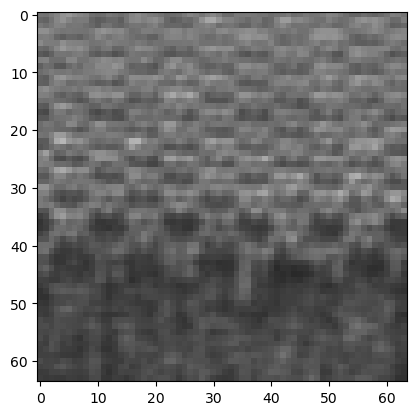

In [146]:
# finally i need to split the training data into training and validation sets

test_size = int(0.2*len(train_features)) # 10%
indexesTest = np.random.randint(0, len(train_features), size=test_size)

p_x_val = []
p_y_val = []
p_x_train = []
p_y_train = []

for i in range(0, len(train_features)):
    if i in indexesTest:
        p_x_val.append(train_features[i])
        p_y_val.append(train_lables[i])
    else:
        p_x_train.append(train_features[i])
        p_y_train.append(train_lables[i])
        
print(p_y_val.count(1))
print(p_y_val.count(0))
print(p_y_train.count(1))
print(p_y_train.count(0))

plt.imshow(p_x_train[100])
plt.show()

In [147]:
# now we need to reshape and norlalise all the date so it can be used in a CNN
N = len(p_x_train)
H = img_size
W = img_size
x_train = np.empty((N, H, W, 3), dtype=np.float32) 
N = len(p_x_val)
x_val = np.empty((N, H, W, 3), dtype=np.float32) 
N = len(test_features)
x_test = np.empty((N, H, W, 3), dtype=np.float32) 


for i in range(0, len(p_x_train)):
    x_train[i] = p_x_train[i]
    
for i in range(0, len(p_x_val)):
    x_val[i] = p_x_val[i]
    
for i in range(0, len(test_features)):
    x_test[i] = test_features[i]
    
    
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_val) / 255


x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(p_y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(p_y_val)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(test_lables)

uniqueV, countsV = np.unique(y_val, return_counts=True)
uniqueT, countsT = np.unique(y_train, return_counts=True)
print(countsV)
print(countsT)

[89 80]
[820 839]


In [148]:
# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range = 180,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0, # Randomly zoom image 
#         width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip = True,  # randomly flip images
#         vertical_flip=False)  # randomly flip images

# datagen.fit(x_train)


In [149]:
# model = Sequential()
# model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(64,64,3)))
# model.add(MaxPool2D())

# model.add(Conv2D(32, 3, padding="same", activation="relu"))
# model.add(MaxPool2D())

# model.add(Conv2D(64, 3, padding="same", activation="relu"))
# model.add(MaxPool2D())
# model.add(Dropout(0.4))

# model.add(Flatten())
# model.add(Dense(128,activation="relu"))
# # model.add(Dense(2, activation="softmax"))
# model.add(Dense(2))



# new -------------------

num_classes = 2
img_height = img_size
img_width = img_size

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 64)       

In [150]:
opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])


In [151]:
history = model.fit(x_train,y_train,epochs = 2 , validation_data = (x_val, y_val))


Epoch 1/2
52/52 [==============================] - 6s 88ms/step - loss: 0.6931 - accuracy: 0.5057 - val_loss: 0.6932 - val_accuracy: 0.4734
Epoch 2/2
52/52 [==============================] - 4s 85ms/step - loss: 0.6931 - accuracy: 0.5057 - val_loss: 0.6932 - val_accuracy: 0.4734


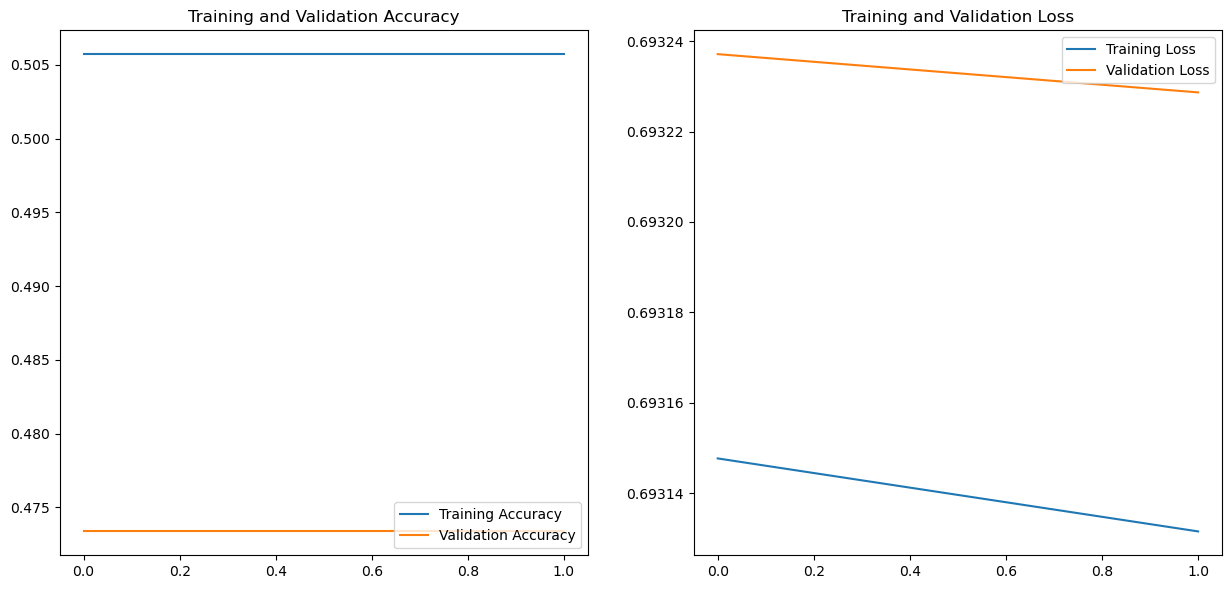

<Figure size 640x480 with 0 Axes>

In [152]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(2)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig("trainingData")

In [155]:
predictions = model.predict(x_val)
print(len(x_val))
print(len(y_val))
classes_x=np.argmax(predictions,axis=1)

print(classes_x)


print(classification_report(y_val, classes_x, target_names = ['Normal (Class 0)','Defect (Class 1)']))

169
169
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [ ]:
cwd = os.getcwd()
model.save_weights(cwd)